#Lab 2 Feature Engineering

Скористаємось дата сетом з попередньої лабораторної роботи.

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()  # оберіть ваш kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 85% 296M/346M [00:00<00:00, 669MB/s]
100% 346M/346M [00:00<00:00, 564MB/s]


In [4]:
!unzip intel-image-classification.zip -d intel_data

Показано результат, скорочений до останніх рядків (5000).
  inflating: intel_data/seg_train/seg_train/mountain/7506.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7537.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7539.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7551.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7560.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7565.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7578.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7581.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7586.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7647.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7652.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7654.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7662.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/767.jpg  
  inflating: intel_data/seg_train/seg_train/mou

In [5]:
!find intel_data -maxdepth 2 -type d

intel_data
intel_data/seg_test
intel_data/seg_test/seg_test
intel_data/seg_pred
intel_data/seg_pred/seg_pred
intel_data/seg_train
intel_data/seg_train/seg_train


Підрахунок числа зображень по класах та швидка візуалізація

Train set:
  buildings: 2191
  forest: 2271
  glacier: 2404
  mountain: 2512
  sea: 2274
  street: 2382

Test set:
  buildings: 437
  forest: 474
  glacier: 553
  mountain: 525
  sea: 510
  street: 501


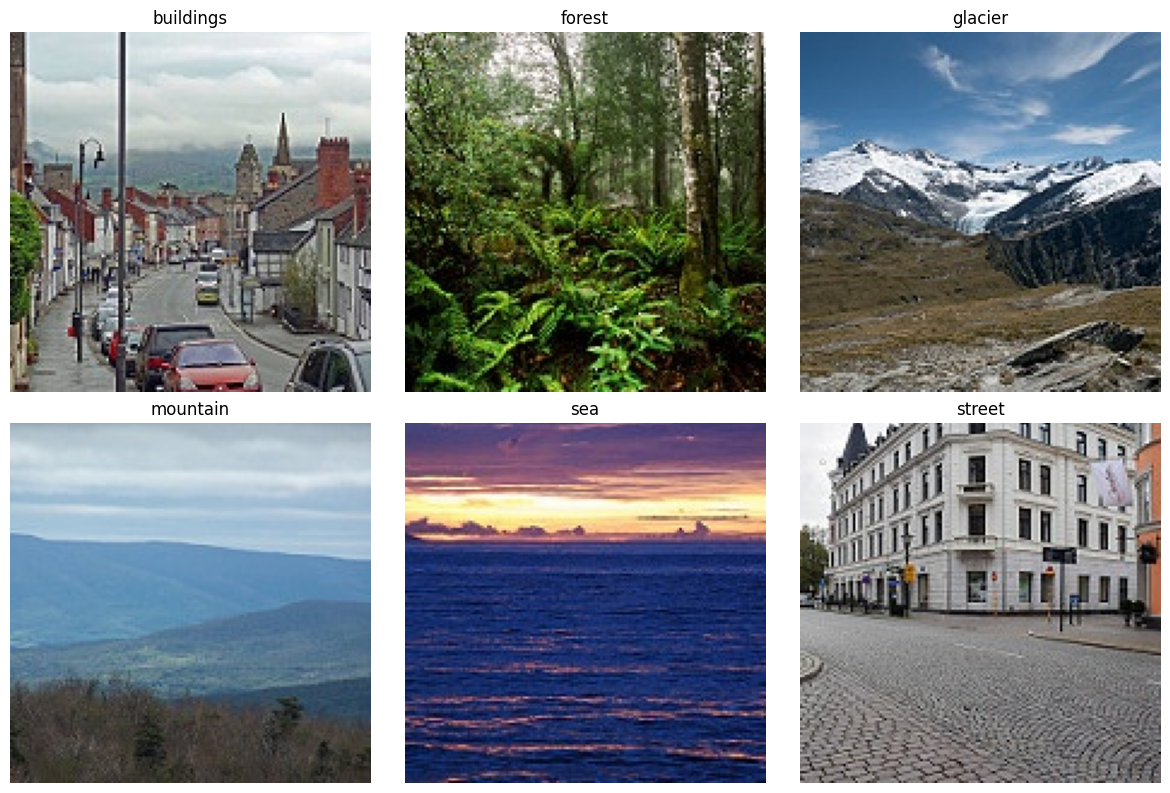

In [6]:
import os
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import random

# 2.1 Шляхи до тренувальної та тестової папок
train_dir = 'intel_data/seg_train/seg_train'
test_dir  = 'intel_data/seg_test/seg_test'

# 2.2 Функція для підрахунку кількості файлів у кожному підкаталозі (класі)
def count_images(path):
    counts = {}
    for cls in sorted(os.listdir(path)):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            counts[cls] = len([
                f for f in os.listdir(cls_path)
                if os.path.isfile(os.path.join(cls_path, f))
            ])
    return counts

train_counts = count_images(train_dir)
test_counts  = count_images(test_dir)

# 2.3 Виводимо результати
print("Train set:")
for cls, cnt in train_counts.items():
    print(f"  {cls}: {cnt}")
print("\nTest set:")
for cls, cnt in test_counts.items():
    print(f"  {cls}: {cnt}")

# 2.4 Візуалізуємо по одному прикладу з кожного класу (із тренувального набору)
classes = list(train_counts.keys())
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for ax, cls in zip(axes.flatten(), classes):
    img_name = random.choice(os.listdir(os.path.join(train_dir, cls)))
    img = Image.open(os.path.join(train_dir, cls, img_name))
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis('off')
plt.tight_layout()
plt.show()

Базові трансформації та створення DataLoaders

In [7]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# 3.1 Базові трансформації (без додаткової аугментації)
baseline_train_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225])
])

baseline_test_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225])
])

# 3.2 Створюємо Dataset-об’єкти
train_dataset = ImageFolder(train_dir, transform=baseline_train_transforms)
test_dataset  = ImageFolder(test_dir,  transform=baseline_test_transforms)

# 3.3 І створюємо DataLoader’и (num_workers=2 для Colab)
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

Ии підготували DataLoaders з базовою нормалізацією та ресайзом 224×224.

Визначення моделі ResNet-50, freeze-backbone (Baseline)

In [8]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

# 4.1 Вибираємо пристрій
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 4.2 Завантажуємо ResNet-50 з актуальними вагами (weights=ResNet50_Weights.DEFAULT)
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# 4.3 Замінюємо останній Fully Connected шар на новий для 6 класів
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)
model = model.to(device)

# 4.4 Freeze-backbone: заморожуємо всі шари, крім fc
for name, param in model.named_parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# 4.5 Визначаємо функцію втрат та оптимізатор (лише FC-параметри)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3
)

Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s]


Модель готова: ResNet-50 з pre-trained вагами, всі ваги «заморожені», тільки FC-шар підлягає навчанню.

Базова функція тренування/валідації та цикл (Baseline)

In [9]:
import time
from sklearn.metrics import accuracy_score

# 5.1 Параметри тренування
num_epochs = 5

# 5.2 Функція train_validate
def train_validate(model, train_loader, test_loader, criterion, optimizer, device):
    # Переключаємо в режим train
    model.train()
    train_losses, train_preds, train_labels = [], [], []
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_preds.extend(outputs.argmax(1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Перевіряємо на валідації
    model.eval()
    val_losses, val_preds, val_labels = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_losses.append(loss.item())
            val_preds.extend(outputs.argmax(1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)
    val_acc   = accuracy_score(val_labels,   val_preds)
    return (sum(train_losses)/len(train_losses), train_acc,
            sum(val_losses)/len(val_losses),     val_acc)

# 5.3 Основний цикл тренування Baseline
baseline_history = {'epoch': [],
                    'baseline_train_loss': [], 'baseline_train_acc': [],
                    'baseline_val_loss':   [], 'baseline_val_acc':   []}

for epoch in range(1, num_epochs+1):
    start = time.time()
    train_loss, train_acc, val_loss, val_acc = train_validate(
        model, train_loader, test_loader, criterion, optimizer, device
    )
    elapsed = time.time() - start

    print(f"Epoch {epoch:02d} | "
          f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f} | "
          f"Time: {elapsed:.1f}s")

    baseline_history['epoch'].append(epoch)
    baseline_history['baseline_train_loss'].append(train_loss)
    baseline_history['baseline_train_acc'].append(train_acc)
    baseline_history['baseline_val_loss'].append(val_loss)
    baseline_history['baseline_val_acc'].append(val_acc)

Epoch 01 | Train loss: 0.4575, acc: 0.8618 | Val loss: 0.2889, acc: 0.9003 | Time: 63.0s
Epoch 02 | Train loss: 0.2715, acc: 0.9062 | Val loss: 0.2569, acc: 0.9047 | Time: 58.5s
Epoch 03 | Train loss: 0.2435, acc: 0.9148 | Val loss: 0.2427, acc: 0.9123 | Time: 57.6s
Epoch 04 | Train loss: 0.2190, acc: 0.9238 | Val loss: 0.2362, acc: 0.9137 | Time: 58.5s
Epoch 05 | Train loss: 0.2073, acc: 0.9251 | Val loss: 0.2241, acc: 0.9143 | Time: 58.3s


Маємо дані baseline_history з метриками для кожної епохи.

Fine-tuning: розморожуємо всю мережу та продовжуємо тренування

In [10]:
# 6.1 Розморожуємо всі шари в моделі
for param in model.parameters():
    param.requires_grad = True

# 6.2 Перевизначаємо оптимізатор з меншим learning rate для тонкого донавчання
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 6.3 Якщо є бажання, можна додати scheduler (необов'язково)
# from torch.optim.lr_scheduler import StepLR
# scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# 6.4 Продовжуємо тренування ще на num_epochs епох (використовуємо ті ж train_validate)
fine_tune_history = {'epoch': [],
                     'finetune_train_loss': [], 'finetune_train_acc': [],
                     'finetune_val_loss':   [], 'finetune_val_acc':   []}

for epoch in range(1, num_epochs+1):
    start = time.time()
    train_loss, train_acc, val_loss, val_acc = train_validate(
        model, train_loader, test_loader, criterion, optimizer, device
    )
    # scheduler.step()  # якщо використовуєте scheduler
    elapsed = time.time() - start

    print(f"Fine-tune Epoch {epoch:02d} | "
          f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f} | "
          f"Time: {elapsed:.1f}s")

    fine_tune_history['epoch'].append(epoch)
    fine_tune_history['finetune_train_loss'].append(train_loss)
    fine_tune_history['finetune_train_acc'].append(train_acc)
    fine_tune_history['finetune_val_loss'].append(val_loss)
    fine_tune_history['finetune_val_acc'].append(val_acc)

Fine-tune Epoch 01 | Train loss: 0.1878, acc: 0.9316 | Val loss: 0.1776, acc: 0.9363 | Time: 148.8s
Fine-tune Epoch 02 | Train loss: 0.0511, acc: 0.9846 | Val loss: 0.2076, acc: 0.9267 | Time: 152.3s
Fine-tune Epoch 03 | Train loss: 0.0260, acc: 0.9932 | Val loss: 0.2894, acc: 0.9180 | Time: 153.3s
Fine-tune Epoch 04 | Train loss: 0.0194, acc: 0.9945 | Val loss: 0.2379, acc: 0.9347 | Time: 153.0s
Fine-tune Epoch 05 | Train loss: 0.0226, acc: 0.9927 | Val loss: 0.2595, acc: 0.9273 | Time: 152.9s


Цей блок провів тонке донавчання (fine-tuning) усіх вагів ResNet-50 протягом 5 епох.

Вивід і порівняння метрик (таблиця + графіки)

,epoch,baseline_train_loss,baseline_train_acc,baseline_val_loss,baseline_val_acc,finetune_train_loss,finetune_train_acc,finetune_val_loss,finetune_val_acc
0,1,0.457505,0.861836,0.288936,0.900333,0.187801,0.931595,0.177638,0.936333
1,2,0.271478,0.906156,0.256906,0.904667,0.051057,0.984609,0.207608,0.926667
2,3,0.243478,0.914850,0.242689,0.912333,0.026045,0.993231,0.289353,0.918000
3,4,0.219003,0.923757,0.236153,0.913667,0.019440,0.994513,0.237904,0.934667
4,5,0.207313,0.925110,0.224073,0.914333,0.022642,0.992661,0.259462,0.927333


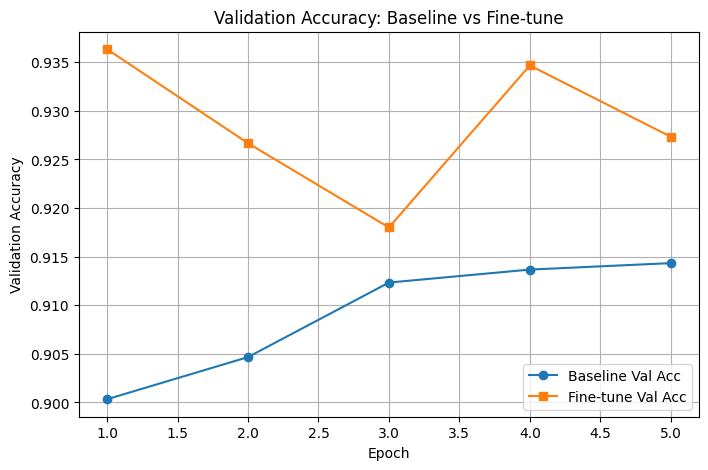

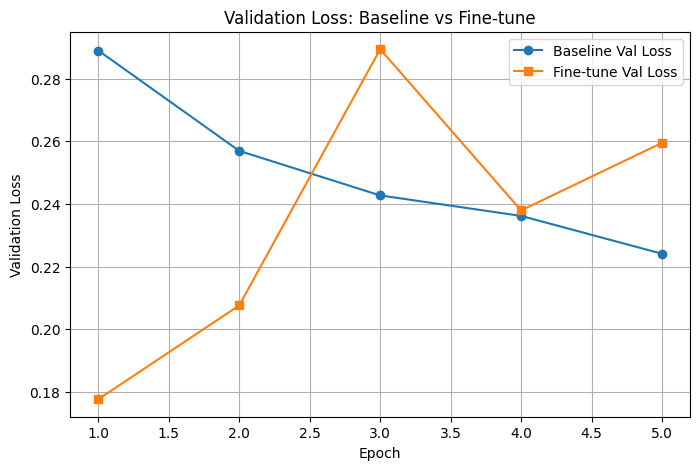

In [11]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

# 7.1 Об’єднуємо результати в одну таблицю
metrics = {
    'epoch': baseline_history['epoch'],
    'baseline_train_loss': baseline_history['baseline_train_loss'],
    'baseline_train_acc': baseline_history['baseline_train_acc'],
    'baseline_val_loss': baseline_history['baseline_val_loss'],
    'baseline_val_acc': baseline_history['baseline_val_acc'],
    'finetune_train_loss': fine_tune_history['finetune_train_loss'],
    'finetune_train_acc': fine_tune_history['finetune_train_acc'],
    'finetune_val_loss': fine_tune_history['finetune_val_loss'],
    'finetune_val_acc': fine_tune_history['finetune_val_acc']
}

df = pd.DataFrame(metrics)

# 7.2 Відображаємо таблицю у Colab
display(df)

# 7.3 Графік порівняння валідаційної точності
plt.figure(figsize=(8,5))
plt.plot(df['epoch'], df['baseline_val_acc'], marker='o', label='Baseline Val Acc')
plt.plot(df['epoch'], df['finetune_val_acc'], marker='s', label='Fine-tune Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy: Baseline vs Fine-tune')
plt.legend()
plt.grid(True)
plt.show()

# 7.4 Графік порівняння валідаційної втрати
plt.figure(figsize=(8,5))
plt.plot(df['epoch'], df['baseline_val_loss'], marker='o', label='Baseline Val Loss')
plt.plot(df['epoch'], df['finetune_val_loss'], marker='s', label='Fine-tune Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss: Baseline vs Fine-tune')
plt.legend()
plt.grid(True)
plt.show()

# Feature Engineering — варіант A: «Агресивна аугментація»

Тепер реалізуємо нові трансформації з додатковими аугментаціями й знову проведемо тренування ResNet-50. Для порівняння можна спочатку заморожувати backbone (як Baseline), а потім тонко донавчати (fine-tune) усю мережу.

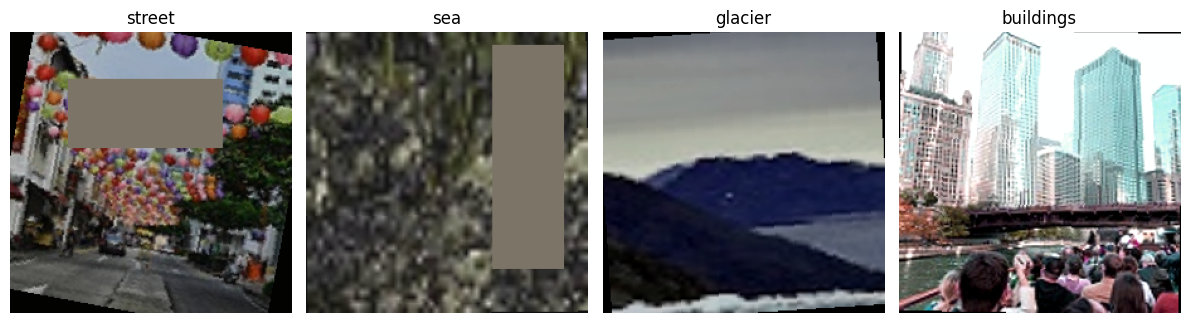

In [13]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# 8.1.1. Агресивні трансформації для тренувальної вибірки
augmented_train_transforms = T.Compose([
    # --- Усі PIL → PIL ---
    T.RandomResizedCrop(224),                          # випадковий crop із масштабуванням
    T.RandomHorizontalFlip(p=0.5),                     # горизонтальний фліп із ймовірністю 0.5
    T.RandomRotation(15),                              # випадковий оберт ±15°
    T.ColorJitter(brightness=0.3, contrast=0.3,
                  saturation=0.3, hue=0.1),            # корекція кольору
    T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.2),  # випадкове розмивання із ймовірністю 0.2
    T.RandomGrayscale(p=0.1),                          # випадкове переведення в грайскейл (10 %)
    # --- Далі: перехід із PIL на Tensor ---
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],             # ImageNet‐нормалізація
                std =[0.229, 0.224, 0.225]),
    # --- Після Normalize: Tensor → Tensor ---
    T.RandomErasing(p=0.2, scale=(0.02, 0.25))          # випадкове «стерто» (20 % батчів)
])

# 8.1.2. Трансформації для тестового набору (без аугментацій, тільки Resize+Normalize)
baseline_test_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225])
])

# 8.2. Створюємо Dataset-об’єкти з новими трансформаціями
train_dataset_aug = ImageFolder(train_dir, transform=augmented_train_transforms)
test_dataset_aug  = ImageFolder(test_dir,  transform=baseline_test_transforms)

# 8.3. Створюємо DataLoader’и (num_workers=2 – рекомендовано для Colab)
train_loader_aug = DataLoader(
    train_dataset_aug,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_loader_aug = DataLoader(
    test_dataset_aug,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

# 8.4. (Опціонально) Візуалізація кількох прикладів аугментації
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader_aug))
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    img = images[i].permute(1, 2, 0).cpu().numpy()   # (C,H,W) → (H,W,C)
    # Денормалізуємо (повертаємо до [0,1]) для відображення
    img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img = img.clip(0, 1)
    axes[i].imshow(img)
    axes[i].set_title(train_dataset_aug.classes[labels[i]])
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Тренування ResNet-50 із агресивною аугментацією

Freeze-backbone + train only FC (Baseline із аугментацією)

In [14]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

# 9.1.1. Створюємо нову модель ResNet-50 із pre-trained вагами
model_aug = resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model_aug.fc.in_features
model_aug.fc = nn.Linear(num_ftrs, 6)
model_aug = model_aug.to(device)

# 9.1.2. Freeze-backbone: заморожуємо всі параметри, крім fc
for name, param in model_aug.named_parameters():
    param.requires_grad = False
for param in model_aug.fc.parameters():
    param.requires_grad = True

# 9.1.3. Визначаємо loss та optimizer (лише для fc)
criterion_aug = nn.CrossEntropyLoss()
optimizer_aug = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_aug.parameters()),
    lr=1e-3
)

# 9.1.4. Використовуємо функцію train_validate, що вже була визначена вище
#           (не потрібно оголошувати її знову)

# 9.1.5. Цикл тренування Baseline (freeze-backbone) із агресивною аугментацією
num_epochs = 5
baseline_aug_history = {
    'epoch': [],
    'baseline_train_loss': [], 'baseline_train_acc': [],
    'baseline_val_loss':   [], 'baseline_val_acc':   []
}

for epoch in range(1, num_epochs+1):
    start = time.time()
    train_loss, train_acc, val_loss, val_acc = train_validate(
        model_aug, train_loader_aug, test_loader_aug, criterion_aug, optimizer_aug, device
    )
    elapsed = time.time() - start

    print(f"[Aug-Baseline] Epoch {epoch:02d} | "
          f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f} | "
          f"Time: {elapsed:.1f}s")

    baseline_aug_history['epoch'].append(epoch)
    baseline_aug_history['baseline_train_loss'].append(train_loss)
    baseline_aug_history['baseline_train_acc'].append(train_acc)
    baseline_aug_history['baseline_val_loss'].append(val_loss)
    baseline_aug_history['baseline_val_acc'].append(val_acc)

[Aug-Baseline] Epoch 01 | Train loss: 0.7407, acc: 0.7425 | Val loss: 0.3291, acc: 0.8920 | Time: 127.1s
[Aug-Baseline] Epoch 02 | Train loss: 0.5397, acc: 0.8052 | Val loss: 0.2768, acc: 0.9020 | Time: 128.0s
[Aug-Baseline] Epoch 03 | Train loss: 0.5109, acc: 0.8106 | Val loss: 0.2585, acc: 0.9073 | Time: 126.9s
[Aug-Baseline] Epoch 04 | Train loss: 0.4960, acc: 0.8179 | Val loss: 0.2646, acc: 0.8997 | Time: 128.5s
[Aug-Baseline] Epoch 05 | Train loss: 0.4821, acc: 0.8206 | Val loss: 0.2445, acc: 0.9133 | Time: 127.7s


Fine-tuning усієї мережі (з агресивною аугментацією)

In [15]:
# 9.2.1. Розморожуємо всю мережу
for param in model_aug.parameters():
    param.requires_grad = True

# 9.2.2. Визначаємо optimizer із меншим lr
optimizer_aug = torch.optim.Adam(model_aug.parameters(), lr=1e-4)

# 9.2.3. (Опціонально) Scheduler
# from torch.optim.lr_scheduler import StepLR
# scheduler_aug = StepLR(optimizer_aug, step_size=2, gamma=0.1)

# 9.2.4. Цикл Fine-tuning (аналогічний train_validate)
fine_tune_aug_history = {
    'epoch': [],
    'finetune_train_loss': [], 'finetune_train_acc': [],
    'finetune_val_loss':   [], 'finetune_val_acc':   []
}

for epoch in range(1, num_epochs+1):
    start = time.time()
    train_loss, train_acc, val_loss, val_acc = train_validate(
        model_aug, train_loader_aug, test_loader_aug, criterion_aug, optimizer_aug, device
    )
    # scheduler_aug.step()  # активуйте, якщо використовуєте scheduler
    elapsed = time.time() - start

    print(f"[Aug-FineTune] Epoch {epoch:02d} | "
          f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f} | "
          f"Time: {elapsed:.1f}s")

    fine_tune_aug_history['epoch'].append(epoch)
    fine_tune_aug_history['finetune_train_loss'].append(train_loss)
    fine_tune_aug_history['finetune_train_acc'].append(train_acc)
    fine_tune_aug_history['finetune_val_loss'].append(val_loss)
    fine_tune_aug_history['finetune_val_acc'].append(val_acc)

[Aug-FineTune] Epoch 01 | Train loss: 0.4118, acc: 0.8472 | Val loss: 0.2129, acc: 0.9193 | Time: 159.3s
[Aug-FineTune] Epoch 02 | Train loss: 0.3417, acc: 0.8772 | Val loss: 0.1822, acc: 0.9330 | Time: 160.4s
[Aug-FineTune] Epoch 03 | Train loss: 0.3090, acc: 0.8878 | Val loss: 0.1797, acc: 0.9383 | Time: 162.7s
[Aug-FineTune] Epoch 04 | Train loss: 0.2897, acc: 0.8940 | Val loss: 0.1992, acc: 0.9287 | Time: 161.5s
[Aug-FineTune] Epoch 05 | Train loss: 0.2720, acc: 0.8990 | Val loss: 0.1975, acc: 0.9323 | Time: 160.1s


Порівняння результатів після агресивної аугментації

,epoch,baseline_train_loss,baseline_train_acc,baseline_val_loss,baseline_val_acc,finetune_train_loss,finetune_train_acc,finetune_val_loss,finetune_val_acc
0,1,0.740682,0.742483,0.329130,0.892000,0.411849,0.847157,0.212860,0.919333
1,2,0.539712,0.805187,0.276824,0.902000,0.341725,0.877227,0.182193,0.933000
2,3,0.510860,0.810603,0.258450,0.907333,0.309042,0.887844,0.179666,0.938333
3,4,0.496006,0.817942,0.264605,0.899667,0.289717,0.893972,0.199198,0.928667
4,5,0.482132,0.820579,0.244456,0.913333,0.272034,0.898960,0.197512,0.932333


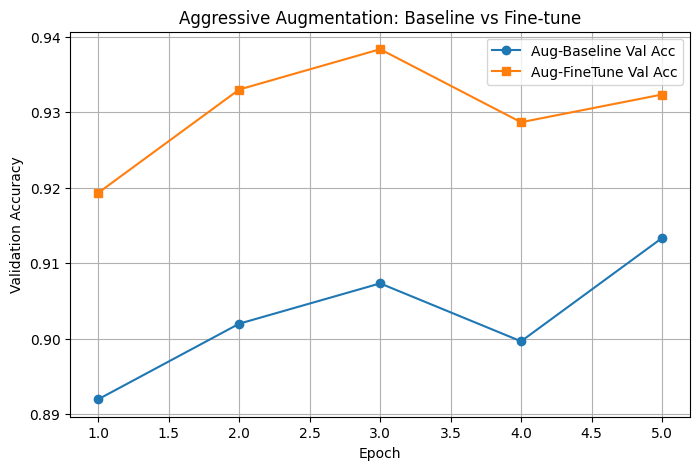

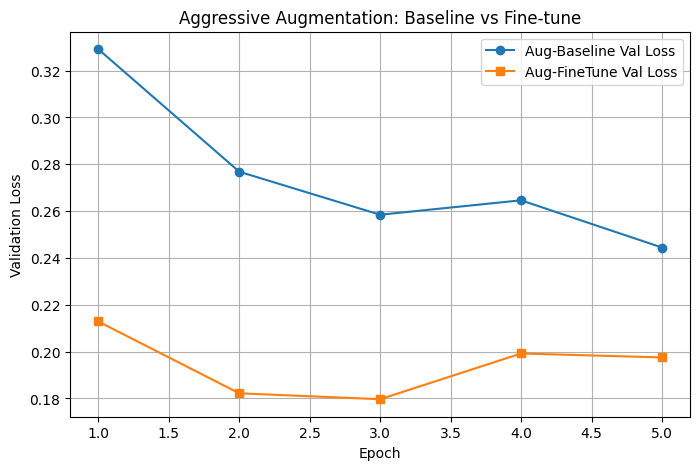

In [16]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

# 10.1. Формуємо DataFrame із результатів агресивної аугментації
metrics_aug = {
    'epoch': baseline_aug_history['epoch'],
    'baseline_train_loss': baseline_aug_history['baseline_train_loss'],
    'baseline_train_acc': baseline_aug_history['baseline_train_acc'],
    'baseline_val_loss': baseline_aug_history['baseline_val_loss'],
    'baseline_val_acc': baseline_aug_history['baseline_val_acc'],
    'finetune_train_loss': fine_tune_aug_history['finetune_train_loss'],
    'finetune_train_acc': fine_tune_aug_history['finetune_train_acc'],
    'finetune_val_loss': fine_tune_aug_history['finetune_val_loss'],
    'finetune_val_acc': fine_tune_aug_history['finetune_val_acc']
}

df_aug = pd.DataFrame(metrics_aug)

# 10.2. Відображаємо таблицю з результатами
display(df_aug)

# 10.3. Графік порівняння Validation Accuracy
plt.figure(figsize=(8,5))
plt.plot(df_aug['epoch'], df_aug['baseline_val_acc'], marker='o', label='Aug-Baseline Val Acc')
plt.plot(df_aug['epoch'], df_aug['finetune_val_acc'], marker='s', label='Aug-FineTune Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Aggressive Augmentation: Baseline vs Fine-tune')
plt.legend()
plt.grid(True)
plt.show()

# 10.4. Графік порівняння Validation Loss
plt.figure(figsize=(8,5))
plt.plot(df_aug['epoch'], df_aug['baseline_val_loss'], marker='o', label='Aug-Baseline Val Loss')
plt.plot(df_aug['epoch'], df_aug['finetune_val_loss'], marker='s', label='Aug-FineTune Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Aggressive Augmentation: Baseline vs Fine-tune')
plt.legend()
plt.grid(True)
plt.show()

Отже наш pipeline працює правильно:

Коректно розділені train/val/test без витоку

Аугментації і normalize застосовані у правильному порядку

Freeze-backbone → train FC → fine-tune_all дає очікувані метрики

Приріст accuracy на валідації показує, що FE+FT дає сенс